# Group Project Proposal: Home Price Regression

## 1. Introduction

#### 1.1 Background Information

Housing prices vary due to a confluence of factors including location, living space, lot size, to name only a few. The extent to which each factor correlates with house prices is not a cut and dry formula. As such, it can be difficult to predict what price one should sell or offer for a house. This project is built to help figure out these values and the variables that affect housing prices.

#### 1.2 Objective Question

Which real estate factors contribute to most accurately predicting the selling price of a home? Can we build a regression model to accurately predict home prices based on given input real estate factors?

#### 1.3 Dataset Description

The dataset comprises data for ~1500 house sales in the city of Ames, Iowa from 2006-2010. The response variable in this dataset is the sale price of each home. Additionally, there are ~80 descriptive real estate factors (including living area, # of bedrooms, and lot size) for each observation.

## 2. Preliminary exploratory data analysis

#### 2.1 Reading in data

In [23]:
# Necessary libraries to install:
# - 'gsheet', 'tidyverse', 'cowplot' , 'tidymodels', 'repr'
install.packages('gsheet')

# Load in libaries
library(tidyverse)
library(cowplot)
library(tidymodels)
library(gsheet)
library(repr)

# Suppress table outputs to a manageable # of rows
options(repr.matrix.max.rows = 8)

# Read data from web
data <- gsheet2tbl('docs.google.com/spreadsheets/d/1nNlzfwXkHVk2i946pgf3247KT2vqCDfHZjrBjT-losg/edit?usp=sharing')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



#### 2.2 Clean and wrangle data

In [24]:
# In this cell, we clean and pre-process the data
# Note: original dataset is already tidy (each obs forms a row, each variable a column, each cell a single measurement)

# Rename invalid column header
names(data)[70] <- "ThreeSsnPorch"

# Select only the columns (variables) that we evaluated as meaningfully and potentially significant
data_selected <- data %>%
    select(Id, MSSubClass, LotArea, LotConfig, Neighborhood, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, Exterior1st, Exterior2nd, TotalBsmtSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch,
           ThreeSsnPorch, 
           ScreenPorch, PoolArea, MoSold, YrSold, SalePrice) %>%
    mutate(HasDeck = WoodDeckSF > 0,HasPorch = (OpenPorchSF > 0 | EnclosedPorch > 0 | ThreeSsnPorch > 0 | ScreenPorch > 0), HasPool = PoolArea > 0, NumTotalBaths = BsmtFullBath + FullBath + 0.5*(BsmtHalfBath + HalfBath)) %>%
    select(-WoodDeckSF, -OpenPorchSF, -EnclosedPorch, -ThreeSsnPorch, -ScreenPorch, -PoolArea, -BsmtFullBath, -BsmtHalfBath, -FullBath, -HalfBath)

# Inspect clean dataframe
data_selected

Id,MSSubClass,LotArea,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,⋯,Fireplaces,GarageCars,GarageArea,MoSold,YrSold,SalePrice,HasDeck,HasPorch,HasPool,NumTotalBaths
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<dbl>
1,60,8450,Inside,CollgCr,1Fam,2Story,7,5,2003,⋯,0,2,548,2,2008,208500,FALSE,TRUE,FALSE,3.5
2,20,9600,FR2,Veenker,1Fam,1Story,6,8,1976,⋯,1,2,460,5,2007,181500,TRUE,FALSE,FALSE,2.5
3,60,11250,Inside,CollgCr,1Fam,2Story,7,5,2001,⋯,1,2,608,9,2008,223500,FALSE,TRUE,FALSE,3.5
4,70,9550,Corner,Crawfor,1Fam,2Story,7,5,1915,⋯,1,3,642,2,2006,140000,FALSE,TRUE,FALSE,2.0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1457,20,13175,Inside,NWAmes,1Fam,1Story,6,6,1978,⋯,2,2,500,2,2010,210000,TRUE,FALSE,FALSE,3.0
1458,70,9042,Inside,Crawfor,1Fam,2Story,7,9,1941,⋯,2,1,252,5,2010,266500,FALSE,TRUE,FALSE,2.0
1459,20,9717,Inside,NAmes,1Fam,1Story,5,6,1950,⋯,0,1,240,4,2010,142125,TRUE,TRUE,FALSE,2.0
1460,20,9937,Inside,Edwards,1Fam,1Story,5,6,1965,⋯,0,1,276,6,2008,147500,TRUE,TRUE,FALSE,2.5


In [9]:
#In this cell we split data into a training and testing set
set.seed(1234)

data_selected <- as.data.frame(data_selected)

data_split <- initial_split(data_selected, prop = 3/4, strata = NULL)
data_train <- training(data_split)
data_test <- testing(data_split)

# Prepare dfs with only numeric and only non-numeric columns (training dataset ONLY) 
data_train_numeric <- select_if(data_train,is.numeric)
data_train_non_numeric <- select_if(data_train,negate(is.numeric))

#### 2.3 Tabular Summary of Data

##### 2.3.1 Summary of numeric variables

In [10]:
# Calculate descriptive summary stats by variable (training data only)
data_counts <- colSums(!is.na(data_train_numeric))
data_unique_counts <- summarize_all(data_train_numeric,n_distinct,na.rm=TRUE)  
data_max <- summarize_all(data_train_numeric,max, na.rm = TRUE)  
data_min <- summarize_all(data_train_numeric,min, na.rm = TRUE)   
data_mean <- summarize_all(data_train_numeric,mean, na.rm = TRUE)   

# Bind summary stats into one summary table
data_observations <- data_counts %>%
    rbind(data_unique_counts) %>%
    rbind(data_max) %>%
    rbind(data_min) %>%
    rbind(data_mean) %>%
    signif(4)

data_observations <- cbind(ObservationType = c("Valid obs count", "Unique count", "Maximum value","Minimum value", "Mean value"), data_observations)

data_observations

ObservationType,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,MoSold,YrSold,SalePrice,NumTotalBaths
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Valid obs count,1095.0,1095.00,1095,1095.000,1095.000,1095,1095,1095,1095,1095.000,1095.000,1095.0000,1095.000,1095.0,1095.000,1095,1095,1095.000
Unique count,1095.0,15.00,831,9.000,9.000,110,61,598,722,3.000,11.000,4.0000,5.000,382.0,12.000,5,547,10.000
Maximum value,1460.0,190.00,215200,10.000,9.000,2009,2010,6110,5642,2.000,14.000,3.0000,4.000,1418.0,12.000,2010,755000,6.000
Minimum value,1.0,20.00,1300,1.000,1.000,1872,1950,0,520,0.000,3.000,0.0000,0.000,0.0,1.000,2006,34900,1.000
Mean value,737.6,57.78,10560,6.113,5.568,1971,1985,1057,1523,1.042,6.542,0.6155,1.769,472.2,6.353,2008,181200,2.213


##### 2.3.2 Summary of non-numeric variables

In [11]:
# Calculate descriptive summary stats by non-numeric variable
non_num_data_counts <- colSums(!is.na(data_train_non_numeric))
non_num_data_unique_counts <- summarize_all(data_train_non_numeric,n_distinct,na.rm=TRUE)  

# Bind summary stats into one summary table
non_num_data_observations <- non_num_data_counts %>%
    rbind(non_num_data_unique_counts)

non_num_data_observations <- cbind(ObservationType = c("Valid obs count", "# of levels"), non_num_data_observations)

non_num_data_observations

ObservationType,LotConfig,Neighborhood,BldgType,HouseStyle,Exterior1st,Exterior2nd,HasDeck,HasPorch,HasPool
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Valid obs count,1095,1095,1095,1095,1095,1095,1095,1095,1095
# of levels,5,25,5,8,14,15,2,2,2


#### 2.4 Visual Summary of Data

##### 2.4.1 Scatterplot grid for quick scan of correlations

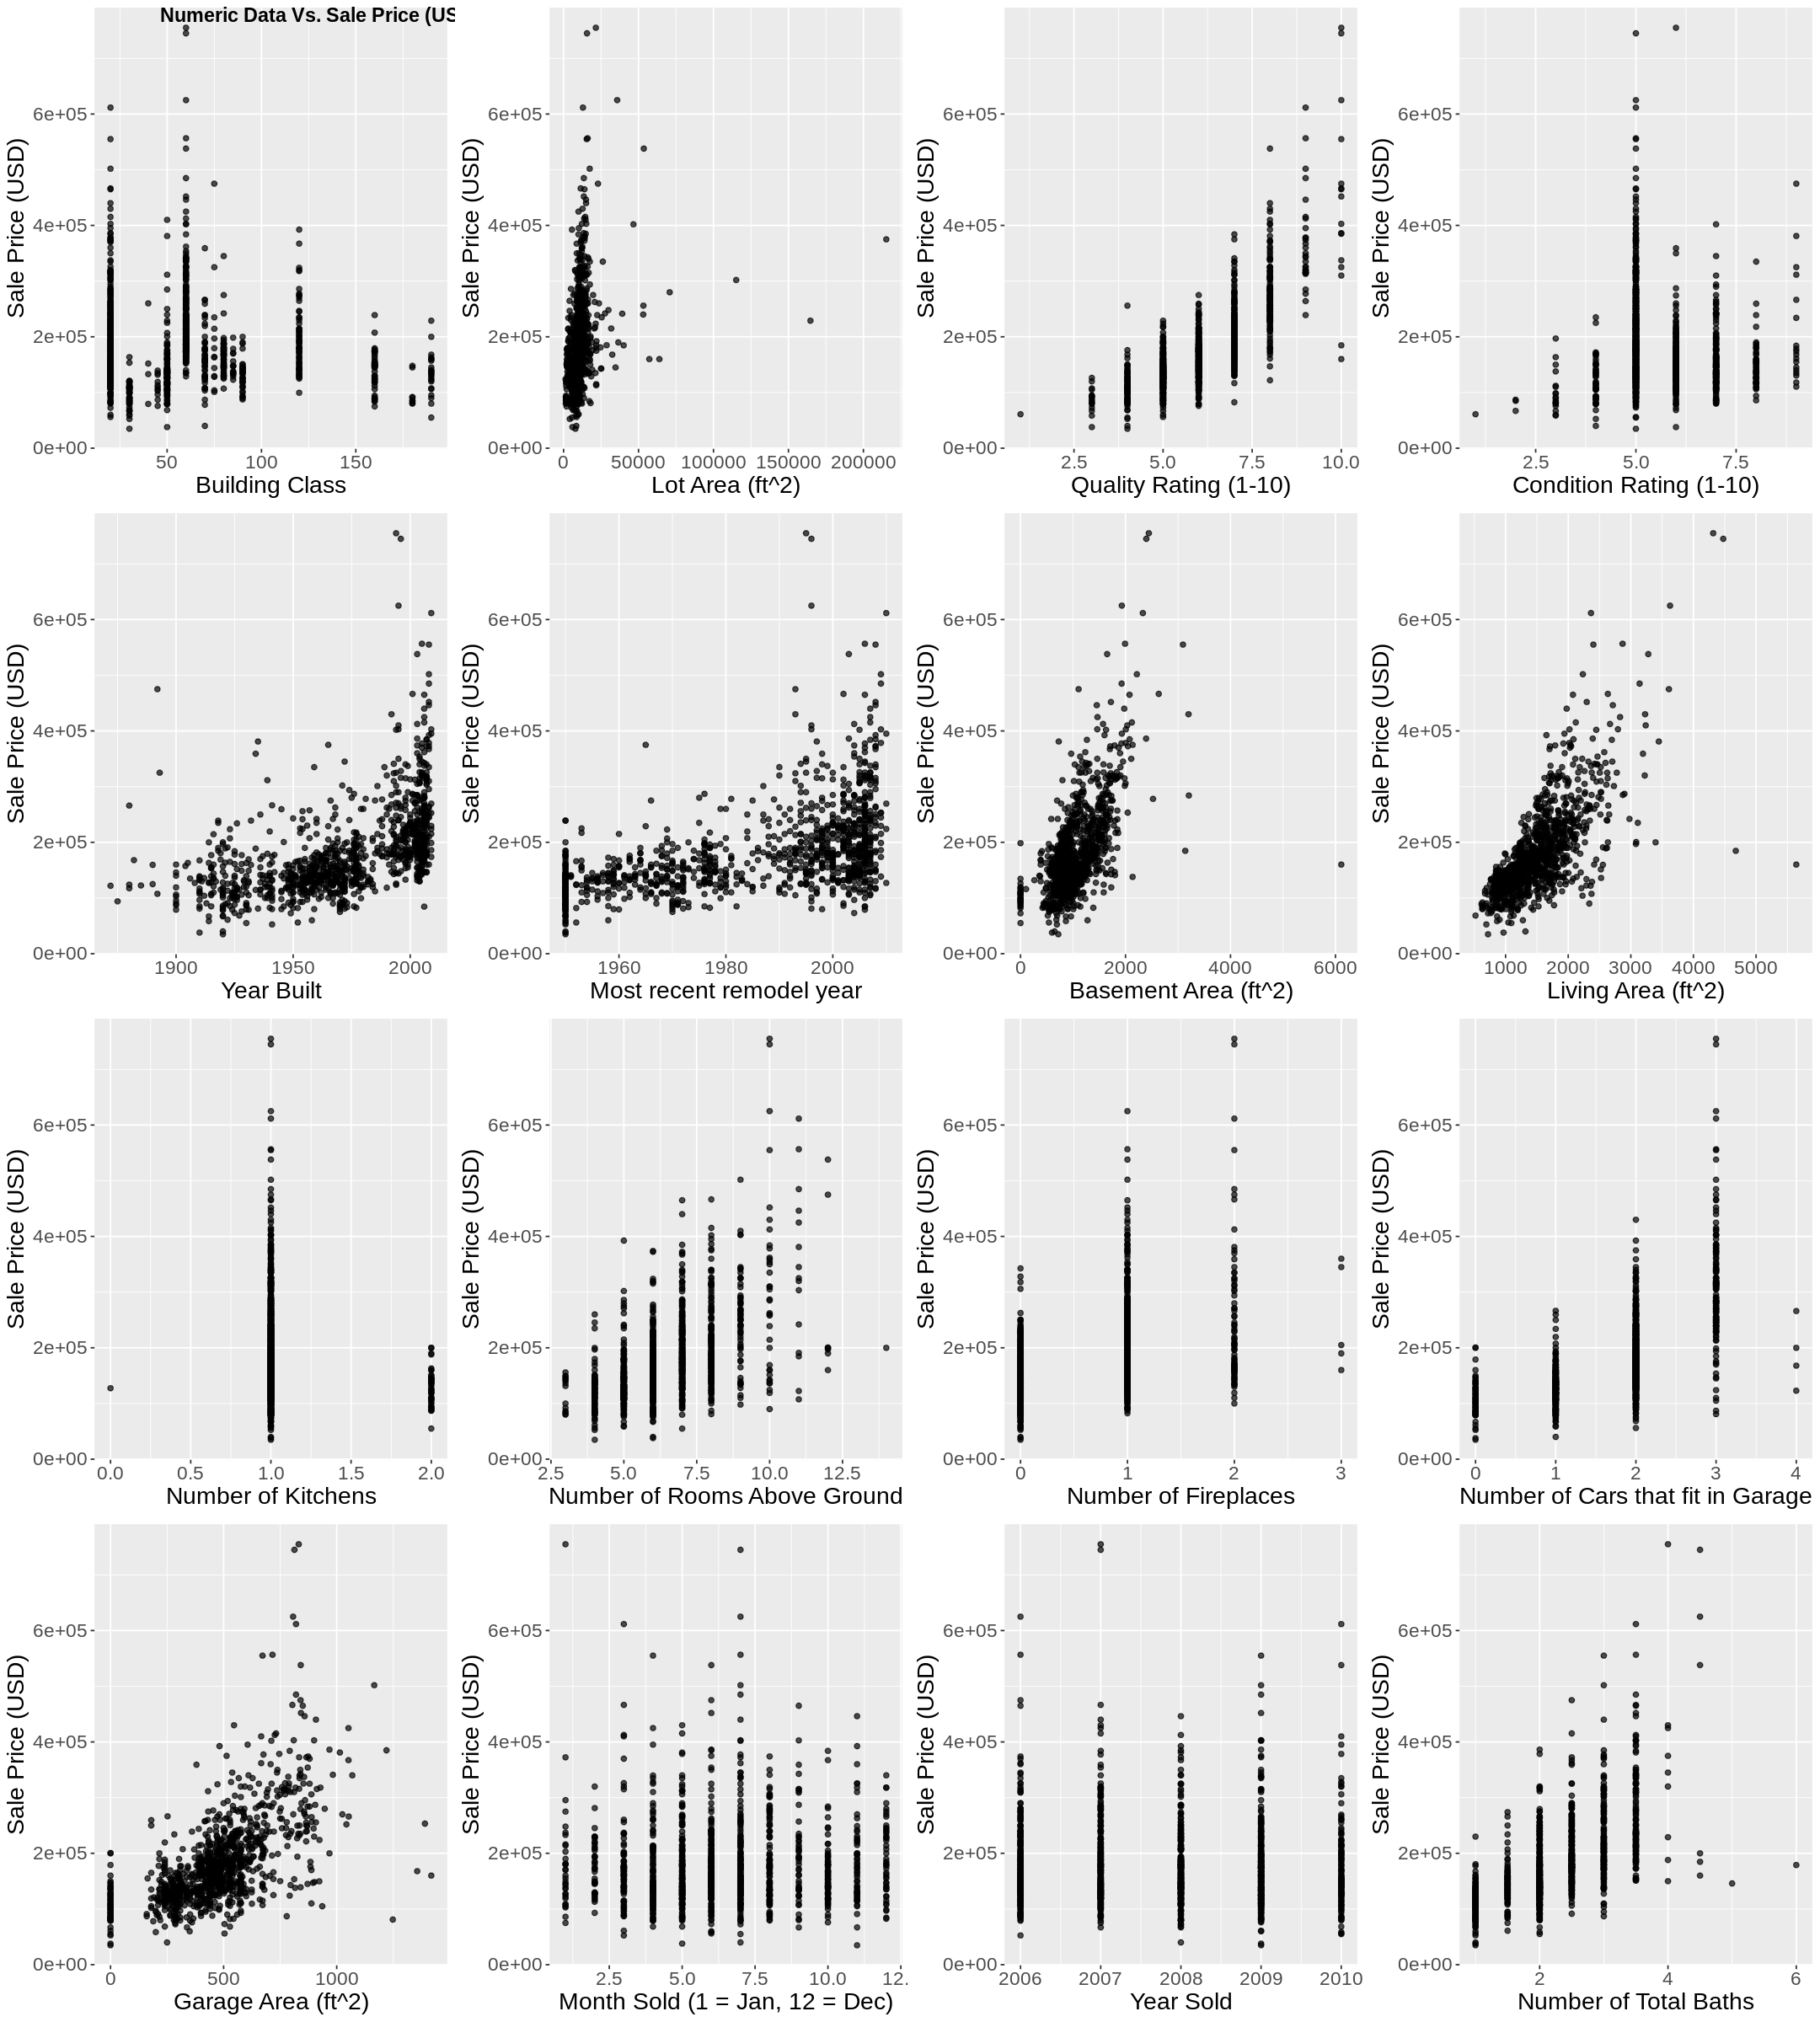

In [29]:
#set plot output size
options(repr.plot.width = 18, repr.plot.height = 20)

#Create a vector with all Numeric variable names neeeded
col_names <- c("Building Class", "Lot Area (ft^2)", "Quality Rating (1-10)", "Condition Rating (1-10)", "Year Built", "Most recent remodel year", "Basement Area (ft^2)", "Living Area (ft^2)","Number of Kitchens","Number of Rooms Above Ground", "Number of Fireplaces", "Number of Cars that fit in Garage", "Garage Area (ft^2)", "Month Sold (1 = Jan, 12 = Dec)", "Year Sold", "Number of Total Baths")

#Remove SalePrice and Id from Numeric data frame
data_without_price <- data_train_numeric %>%
    select(-Id,-SalePrice)

plot_list <- list()

#Plot all Numeric variables against SalePrice
for (i in 1:length(names(data_without_price))){
    new_data <- cbind(x_var = data_without_price[i],y_var = data_train_numeric$SalePrice)
    new_data <- rename(new_data, x_var = 1)
    plot <- ggplot(new_data, aes(y=y_var, x=x_var)) +
        geom_point(alpha = 0.7) +
        labs(y = "Sale Price (USD)", x = col_names[i]) + theme(text = element_text(size=17))
    plot_list[[i]] <- plot
}

plot_grid(plotlist = plot_list)


##### 2.4.2 Sale price by living area size and year built

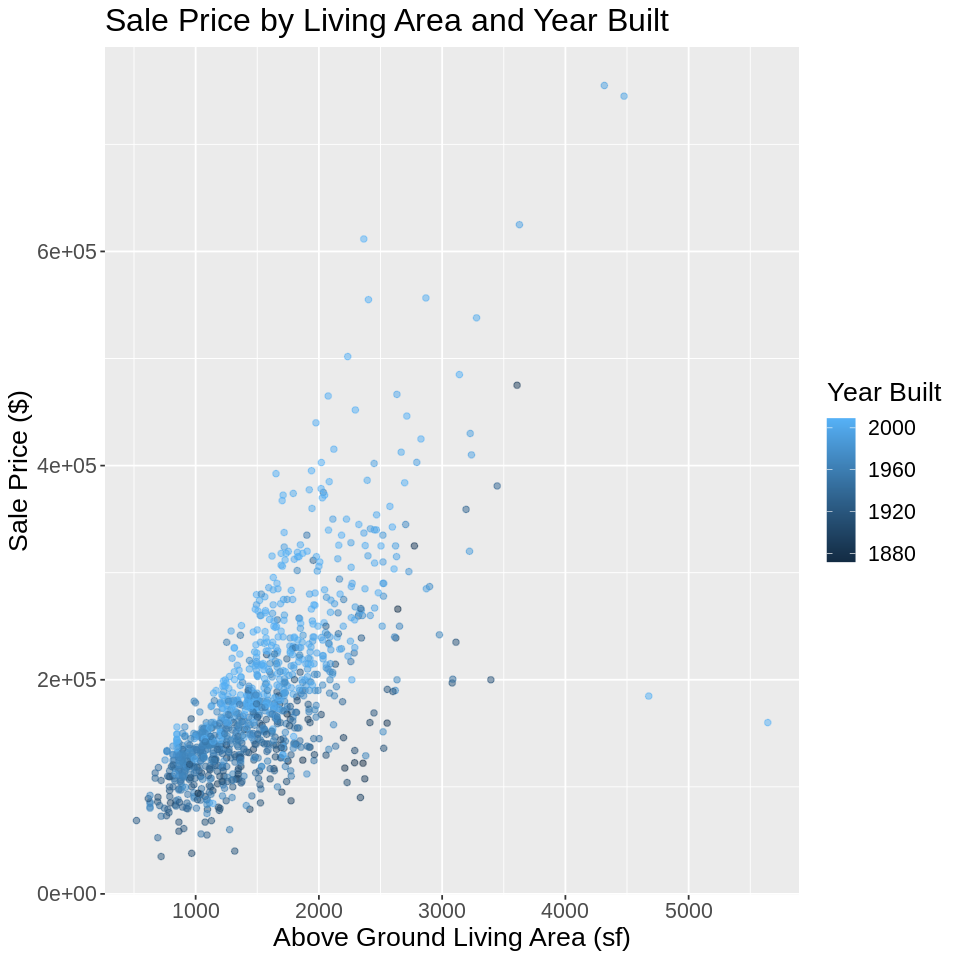

In [29]:
# set plot output size
options(repr.plot.width = 8, repr.plot.height = 8)

# create scatterplot
exterior_plot<- ggplot( data_train, aes(x=GrLivArea , y=SalePrice, color= YearBuilt) ) + 
        geom_point(alpha = 0.5) +
        labs(x = "Above Ground Living Area (sf)", y = "Sale Price ($)", colour = "Year Built") +
        ggtitle("Sale Price by Living Area and Year Built") +
        theme(text = element_text(size = 16))
        
exterior_plot

## 3. Methods

In order to determine which factors contribute to most accurately predicting selling price, 
we will construct a multivariate linear regression model. Below is an overview of our proposed methods:
- Reduce the number of <em>potential</em> explanatory variables from ~80 to 25 (refer to section 2.2)
- Clean, organize, and summarize the dataset (sections 2.2-2.4)
- Explore and document pairwise relationships using graphical and statistical analysis
- Conduct variable selection analysis to narrow down to a "best subset" of explanatory variables, leveraging the R 'leaps' and 'caret' packages
- Tune model for a final result
- Visualize our results with fitted vs. residual plots

Throughout the process, we will be evaluating not only statistical significance but also interpretability and meaningfulness of our results. Our imperative is to produce a final result that we can explain in plain English.

## 4. Expected outcomes and significance

#### 4.1 Expected findings

We expect to find that size the measurments (square footage, # of bedrooms, etc.) of the home will be most positively correlated to selling price. Furthermore, we anticipate that recently renovated homes will exhibit higher predicted values than non-renovated homes. Finally, we expect an element of the unexpected. That is, we hypothesize that we will find factors that will significantly contribute to the price that we didn't expect.

#### 4.2 Potential impact

In our view, there are two notable potential impacts from this work: 
1. Real estate agents could garner a better understanding into the drivers of home selling prices.
2. We can take key valuation insights with us in our personal life for when we one day purchase homes of our own.

#### 4.3 Potential future questions

Our analysis on factors contributing to the selling price of a home could spark future questions, including:

- How has the weight of each factor that contributes to the selling price changed over time? Is there a pattern to this change?
- Do the factors contributing most to selling prices in Ames, Iowa (our dataset) also work for other regions?